# An Exploration of UW Pharmacy Student Reflections

Author: 

## Libraries and Dependencies

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline


import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


import re
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis

import spacy

[nltk_data] Downloading package stopwords to /Users/bing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import and Pre-process Data

In [134]:
data = pd.read_csv("data/choiceboard_data.csv")[["CPD_Q1", "CPD_Q3"]]
data.head()

,CPD_Q1,CPD_Q3
0,The class time devoted to health and wellness ...,I believe self-care to be really important in ...
1,The class time devoted to health and wellness ...,The time spent on my choice of self-care allow...
2,The class time has reminded me on the importan...,The time spent on my choice of self care affec...
3,The class time that was devoted to health and ...,It made me more relaxed and less stressed abou...
4,I have learnt to listen to people without inte...,This has been a lifeline because I always felt...


In [109]:
corpus_1 = data["CPD_Q1"].dropna()
corpus_1 = corpus_1.astype(str)
corpus_1

0      The class time devoted to health and wellness ...
1      The class time devoted to health and wellness ...
2      The class time has reminded me on the importan...
3      The class time that was devoted to health and ...
4      I have learnt to listen to people without inte...
                             ...                        
103    It’s been a wonderful change of pace to have a...
104    The mentor team discussions with my team and p...
105    The class time devoted to health, wellness, an...
106    I personally think it was a nice break, but I ...
107    I actively disliked most of the content relate...
Name: CPD_Q1, Length: 105, dtype: object

In [110]:
corpus_2 = data["CPD_Q3"].dropna()
corpus_2 = corpus_2.astype(str)
corpus_2

0      I believe self-care to be really important in ...
1      The time spent on my choice of self-care allow...
2      The time spent on my choice of self care affec...
3      It made me more relaxed and less stressed abou...
4      This has been a lifeline because I always felt...
                             ...                        
102    The way how the time spent on my choices of se...
103    For myself, life is a constant balance of bein...
104    Time spent on self-care helped me take a menta...
106      It gave me a small break to think about myself.
107    It was nice, but I don’t think it really affec...
Name: CPD_Q3, Length: 104, dtype: object

In [111]:
#adding clearly neutral stopwords that are specific to this program or activity

stopwords = nltk.corpus.stopwords.words('english')

stopwords.append('pharmacy')
stopwords.append('pharmacist')
stopwords.append('pharmacists')
stopwords.append('health')
stopwords.append('healthcare')
stopwords.append('practitioner')
stopwords.append('mental')
stopwords.append('wellness')
stopwords.append('self-care')
stopwords.append('mentor')
stopwords.append('WIP')
stopwords.append('class')
stopwords.append('school')
stopwords.append('peers')
stopwords.append('classmates')
stopwords.append('quarter')
stopwords.append('spring')
stopwords.append('winter')
stopwords.append('fall')

#Removed words after EDA 
stopwords.append('also')
stopwords.append('really')

stopwords = list(stopwords)

In [112]:
#using sample of words from full corpus

sample = pd.DataFrame(corpus_1).reset_index()[['CPD_Q1']]
sample2 = pd.DataFrame(corpus_2).reset_index()[['CPD_Q3']]

nltk.download('punkt')

sample['CPD_Q1'] = sample['CPD_Q1'].map(lambda x: x.lower())
sample['CPD_Q1'] = sample['CPD_Q1'].apply(lambda x: [token for token in nltk.word_tokenize(x) if token.isalnum()])
sample.head()


sample2['CPD_Q3'] = sample2['CPD_Q3'].map(lambda x: x.lower())
sample2['CPD_Q3'] = sample2['CPD_Q3'].apply(lambda x: [token for token in nltk.word_tokenize(x) if token.isalnum()])
sample2.head()

[nltk_data] Downloading package punkt to /Users/bing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,CPD_Q3
0,"[i, believe, to, be, really, important, in, li..."
1,"[the, time, spent, on, my, choice, of, allowed..."
2,"[the, time, spent, on, my, choice, of, self, c..."
3,"[it, made, me, more, relaxed, and, less, stres..."
4,"[this, has, been, a, lifeline, because, i, alw..."


In [113]:
def remove_stopwords(word_list):
    filtered_tokens = [word for word in word_list if word.lower() not in stopwords]
    return filtered_tokens

sample['CPD_Q1'] = sample['CPD_Q1'].apply(remove_stopwords)
sample2['CPD_Q3'] = sample2['CPD_Q3'].apply(remove_stopwords)

display(sample)
display(sample2)

,CPD_Q1
0,"[time, devoted, positive, effect, fairly, good..."
1,"[time, devoted, helped, spend, time, enjoy, ti..."
2,"[time, reminded, importance, self, care, peopl..."
3,"[time, devoted, nice, allowed, time, away, wor..."
4,"[learnt, listen, people, without, interrupting..."
...,...
100,"[wonderful, change, pace, little, time, especi..."
101,"[team, discussions, team, professor, helped, b..."
102,"[time, devoted, helped, throughout, year, ackn..."
103,"[personally, think, nice, break, could, used, ..."


,CPD_Q3
0,"[believe, important, living, healthy, balanced..."
1,"[time, spent, choice, allowed, relax, mind, st..."
2,"[time, spent, choice, self, care, affected, po..."
3,"[made, relaxed, less, stressed, upcoming, futu..."
4,"[lifeline, always, felt, like, wasting, time, ..."
...,...
99,"[way, time, spent, choices, affected, would, a..."
100,"[life, constant, balance, happy, busy, always,..."
101,"[time, spent, helped, take, break, studying, s..."
102,"[gave, small, break, think]"


## Stemming the Responses ##

In [123]:
nltk.download('punkt')

stem_sample2 = sample2.copy()

# Create a stemmer instance
stemmer = PorterStemmer()

# Define a function to apply stemming to a list of words
def stem_word_list(word_list):
    stemmed_words = [stemmer.stem(word) for word in word_list]
    return stemmed_words

# Assuming your DataFrame is called stem_sample, and 'CPD_Q1' column contains lists of words
stem_sample2['stemmed_words'] = stem_sample2['CPD_Q3'].apply(stem_word_list)

# If you want to convert the stemmed words back to a single string, you can do the following:
stem_sample2['stemmed_text'] = stem_sample2['stemmed_words'].apply(lambda x: ' '.join(x))

stem_sample2

[nltk_data] Downloading package punkt to /Users/bing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,CPD_Q3,stemmed_words,stemmed_text
0,"[believe, important, living, healthy, balanced...","[believ, import, live, healthi, balanc, lifest...",believ import live healthi balanc lifestyl tim...
1,"[time, spent, choice, allowed, relax, mind, st...","[time, spent, choic, allow, relax, mind, step,...",time spent choic allow relax mind step away wo...
2,"[time, spent, choice, self, care, affected, po...","[time, spent, choic, self, care, affect, posit...",time spent choic self care affect posit way wo...
3,"[made, relaxed, less, stressed, upcoming, futu...","[made, relax, less, stress, upcom, futur, exam...",made relax less stress upcom futur exam work m...
4,"[lifeline, always, felt, like, wasting, time, ...","[lifelin, alway, felt, like, wast, time, walk,...",lifelin alway felt like wast time walk away co...
...,...,...,...
99,"[way, time, spent, choices, affected, would, a...","[way, time, spent, choic, affect, would, allow...",way time spent choic affect would allow improv...
100,"[life, constant, balance, happy, busy, always,...","[life, constant, balanc, happi, busi, alway, t...",life constant balanc happi busi alway tri find...
101,"[time, spent, helped, take, break, studying, s...","[time, spent, help, take, break, studi, stress...",time spent help take break studi stress refocu...
102,"[gave, small, break, think]","[gave, small, break, think]",gave small break think


In [122]:
import nltk
from nltk.stem import PorterStemmer

nltk.download('punkt')

stem_sample = sample.copy()

# Create a stemmer instance
stemmer = PorterStemmer()

# Define a function to apply stemming to a list of words
def stem_word_list(word_list):
    stemmed_words = [stemmer.stem(word) for word in word_list]
    return stemmed_words

# Assuming your DataFrame is called stem_sample, and 'CPD_Q1' column contains lists of words
stem_sample['stemmed_words'] = stem_sample['CPD_Q1'].apply(stem_word_list)

stem_sample['stemmed_text'] = stem_sample['stemmed_words'].apply(lambda x: ' '.join(x))
# If you want to convert the stemmed words back to a single string, you can do the following:

stem_sample

[nltk_data] Downloading package punkt to /Users/bing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,CPD_Q1,stemmed_words,stemmed_text
0,"[time, devoted, positive, effect, fairly, good...","[time, devot, posit, effect, fairli, good, fin...",time devot posit effect fairli good find pocke...
1,"[time, devoted, helped, spend, time, enjoy, ti...","[time, devot, help, spend, time, enjoy, time, ...",time devot help spend time enjoy time devot ma...
2,"[time, reminded, importance, self, care, peopl...","[time, remind, import, self, care, peopl, go, ...",time remind import self care peopl go thing no...
3,"[time, devoted, nice, allowed, time, away, wor...","[time, devot, nice, allow, time, away, work, r...",time devot nice allow time away work relax lit...
4,"[learnt, listen, people, without, interrupting...","[learnt, listen, peopl, without, interrupt, le...",learnt listen peopl without interrupt learnt f...
...,...,...,...
100,"[wonderful, change, pace, little, time, especi...","[wonder, chang, pace, littl, time, especi, dem...",wonder chang pace littl time especi demand cla...
101,"[team, discussions, team, professor, helped, b...","[team, discuss, team, professor, help, build, ...",team discuss team professor help build sens co...
102,"[time, devoted, helped, throughout, year, ackn...","[time, devot, help, throughout, year, acknowle...",time devot help throughout year acknowledg emo...
103,"[personally, think, nice, break, could, used, ...","[person, think, nice, break, could, use, focu,...",person think nice break could use focu rather ...


# EDA I think #

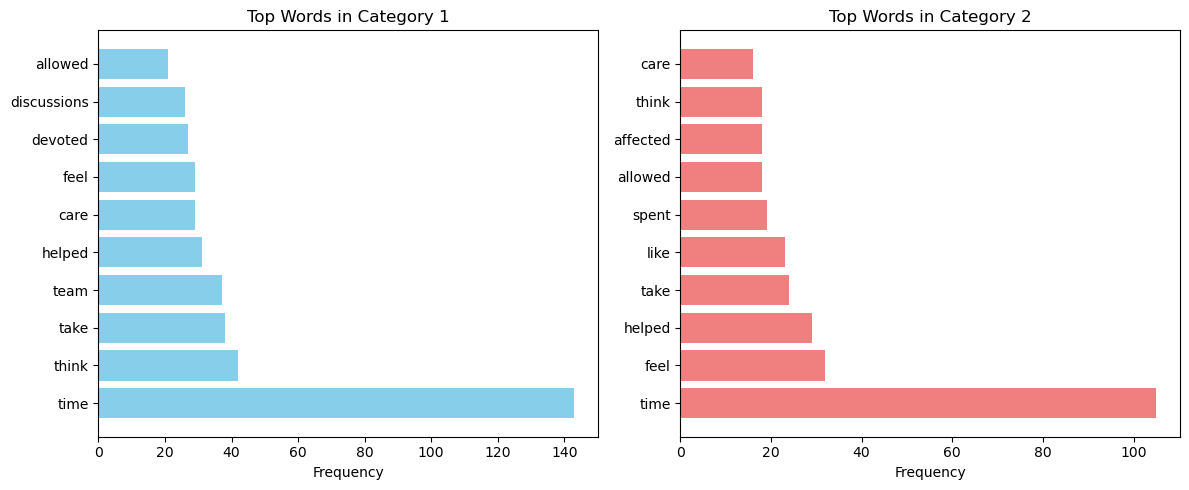

In [114]:
Q1_word_list = [word for sublist in sample['CPD_Q1'] for word in sublist]
Q3_word_list = [word for sublist in sample2['CPD_Q3'] for word in sublist]

Q1_word_freq = Counter(Q1_word_list)
Q3_word_freq = Counter(Q3_word_list)

# Plot the top N most frequent words
N = 10  # Change N to display more or fewer words
commonQ1_words = Q1_word_freq.most_common(N)
commonQ3_words = Q3_word_freq.most_common(N)

words1, frequencies1 = zip(*commonQ1_words)
words3, frequencies3 = zip(*commonQ3_words)

# Create a figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.barh(words1, frequencies1, color='skyblue')
ax1.set_xlabel('Frequency')
ax1.set_title('Top Words in Category 1')


ax2.barh(words3, frequencies3, color='lightcoral')
ax2.set_xlabel('Frequency')
ax2.set_title('Top Words in Category 2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Most Common 2-grams:
('time', 'spent'): 19
('feel', 'like'): 8
('spent', 'choice'): 7
('take', 'care'): 7
('self', 'care'): 6
('affected', 'positive'): 6
('felt', 'like'): 6
('time', 'spend'): 5
('positive', 'way'): 5
('taking', 'time'): 5


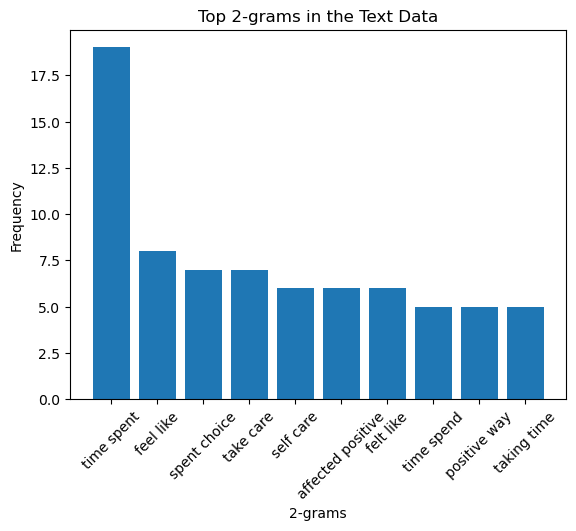

In [115]:
# Import the required libraries
import pandas as pd
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

n_grams2df = sample2.copy()

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

n = 2  # Set 'n' to the desired N-gram size (e.g., 2 for bigrams)

# Assuming 'sample' is a DataFrame and 'CPD_Q1' column contains tokenized words
# If 'CPD_Q1' contains strings of comma-separated words, convert them to a list of words (tokens)
n_grams2df['CPD_Q3'] = n_grams2df['CPD_Q3'].apply(lambda x: x if isinstance(x, list) else x.split(','))

# Extract N-grams from the token lists
n_grams2df['Ngrams'] = n_grams2df['CPD_Q3'].apply(lambda x: extract_ngrams(x, n))

# Flatten the list of N-grams
ngrams_flat = [ngram for sublist in n_grams2df['Ngrams'] for ngram in sublist]

# Count the frequency of each N-gram
ngram_counts = Counter(ngrams_flat)

# Display the most common N-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print("Most Common {}-grams:".format(2))
for ngram, count in most_common_ngrams:
    print("{}: {}".format(ngram, count))

# Create a bar plot of the top N-grams
top_ngrams = dict(most_common_ngrams)
# Convert tuple bigrams into strings for plotting
bigram_strings = [' '.join(bigram) for bigram in top_ngrams.keys()]

plt.bar(range(len(top_ngrams)), top_ngrams.values())
plt.xlabel("{}-grams".format(n))
plt.ylabel("Frequency")
plt.title("Top {}-grams in the Text Data".format(n))
# Set the x-ticks to be the string representation of the bigrams
plt.xticks(range(len(top_ngrams)), bigram_strings, rotation=45)
plt.show()

Most Common 2-grams:
('time', 'devoted'): 25
('team', 'discussions'): 21
('take', 'care'): 15
('take', 'time'): 8
('self', 'care'): 6
('past', '3'): 6
('devoted', 'helped'): 5
('little', 'bit'): 5
('allowed', 'time'): 5
('quarters', 'time'): 5


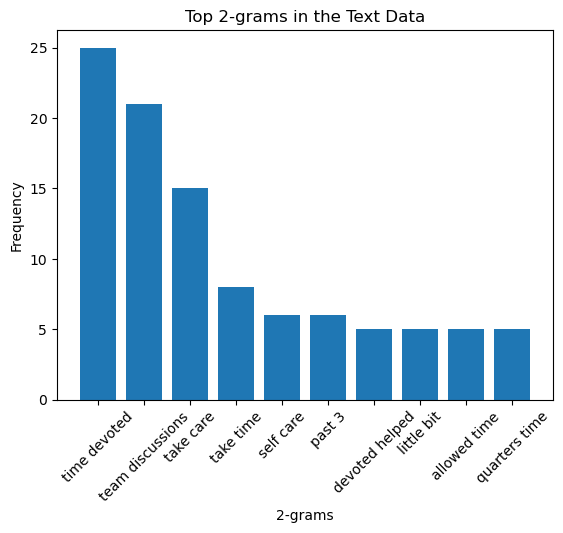

In [124]:
# Import the required libraries
import pandas as pd
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

n_gramsdf = sample.copy()

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

n = 2  # Set 'n' to the desired N-gram size (e.g., 2 for bigrams)

# Assuming 'sample' is a DataFrame and 'CPD_Q1' column contains tokenized words
# If 'CPD_Q1' contains strings of comma-separated words, convert them to a list of words (tokens)
n_gramsdf['CPD_Q1'] = n_gramsdf['CPD_Q1'].apply(lambda x: x if isinstance(x, list) else x.split(','))

# Extract N-grams from the token lists
n_gramsdf['Ngrams'] = n_gramsdf['CPD_Q1'].apply(lambda x: extract_ngrams(x, n))

# Flatten the list of N-grams
ngrams_flat = [ngram for sublist in n_gramsdf['Ngrams'] for ngram in sublist]

# Count the frequency of each N-gram
ngram_counts = Counter(ngrams_flat)

# Display the most common N-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print("Most Common {}-grams:".format(2))
for ngram, count in most_common_ngrams:
    print("{}: {}".format(ngram, count))

# Create a bar plot of the top N-grams
top_ngrams = dict(most_common_ngrams)
# Convert tuple bigrams into strings for plotting
bigram_strings = [' '.join(bigram) for bigram in top_ngrams.keys()]

plt.bar(range(len(top_ngrams)), top_ngrams.values())
plt.xlabel("{}-grams".format(n))
plt.ylabel("Frequency")
plt.title("Top {}-grams in the Text Data".format(n))
# Set the x-ticks to be the string representation of the bigrams
plt.xticks(range(len(top_ngrams)), bigram_strings, rotation=45)
plt.show()

/Users/bing/miniconda3/envs/newenv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


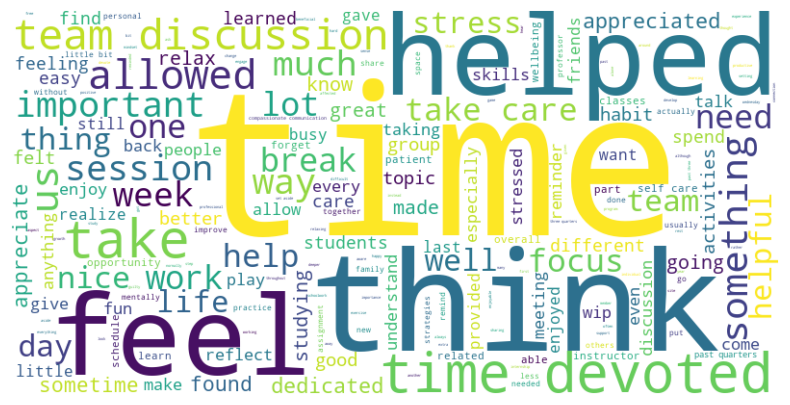

In [127]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloudq1 = sample.copy()

# Join the tokenized words into a single string for the word cloud
text_data = " ".join(" ".join(response) for response in word_cloudq1['CPD_Q1'])

# Create and configure the WordCloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200,
)

# Generate the word cloud
wordcloud.generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide the axis
plt.show()


/Users/bing/miniconda3/envs/newenv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


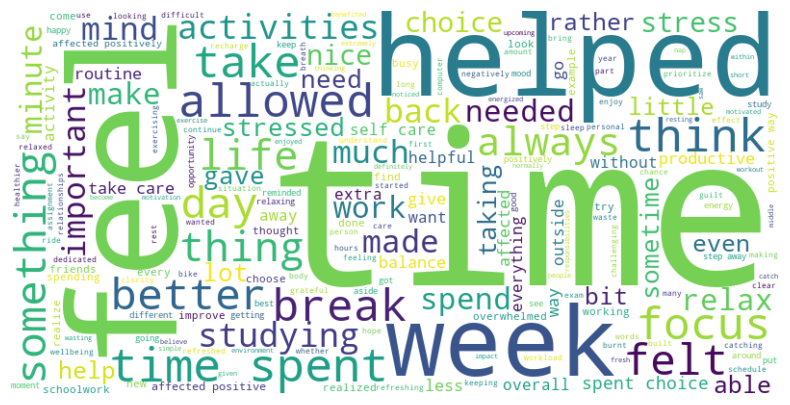

In [128]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloudq3 = sample2.copy()

# Join the tokenized words into a single string for the word cloud
text_data = " ".join(" ".join(response) for response in word_cloudq3['CPD_Q3'])

# Create and configure the WordCloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200,
)

# Generate the word cloud
wordcloud.generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide the axis
plt.show()


In [132]:
from textblob import TextBlob

sentq1 = sample.copy()

# Create a function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(" ".join(text))
    # Sentiment polarity ranges from -1 (negative) to 1 (positive)
    sentiment_polarity = analysis.sentiment.polarity
    return sentiment_polarity

# Apply the sentiment analysis function to your DataFrame
sentq1['sentiment_polarity'] = sentq1['CPD_Q1'].apply(calculate_sentiment)

# Categorize the sentiment based on polarity (you can define your own thresholds)
def categorize_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment categorization function to your DataFrame
sentq1['sentiment_category'] = sentq1['sentiment_polarity'].apply(categorize_sentiment)

# Display the DataFrame with sentiment scores and categories
sentq1[['CPD_Q1', 'sentiment_polarity', 'sentiment_category']]

,CPD_Q1,sentiment_polarity,sentiment_category
0,"[time, devoted, positive, effect, fairly, good...",0.268615,Positive
1,"[time, devoted, helped, spend, time, enjoy, ti...",0.240000,Positive
2,"[time, reminded, importance, self, care, peopl...",0.078125,Positive
3,"[time, devoted, nice, allowed, time, away, wor...",0.206250,Positive
4,"[learnt, listen, people, without, interrupting...",0.000000,Neutral
...,...,...,...
100,"[wonderful, change, pace, little, time, especi...",0.270833,Positive
101,"[team, discussions, team, professor, helped, b...",0.000000,Neutral
102,"[time, devoted, helped, throughout, year, ackn...",0.100000,Positive
103,"[personally, think, nice, break, could, used, ...",0.430000,Positive


In [135]:
from textblob import TextBlob

sentq3 = sample2.copy()

# Create a function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(" ".join(text))
    # Sentiment polarity ranges from -1 (negative) to 1 (positive)
    sentiment_polarity = analysis.sentiment.polarity
    return sentiment_polarity

# Apply the sentiment analysis function to your DataFrame
sentq3['sentiment_polarity'] = sentq3['CPD_Q3'].apply(calculate_sentiment)

# Categorize the sentiment based on polarity (you can define your own thresholds)
def categorize_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment categorization function to your DataFrame
sentq3['sentiment_category'] = sentq3['sentiment_polarity'].apply(categorize_sentiment)

# Display the DataFrame with sentiment scores and categories
sentq1[['CPD_Q3', 'sentiment_polarity', 'sentiment_category']]

KeyError: "['CPD_Q3'] not in index"